<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter03/Steps_to_build_a_neural_network_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3.4 训练神经网络

In [1]:
# 1. 导入相关程序包和FMNIST数据集
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = 'data/FMNIST' # This can be any directory you want to
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to data/FMNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data/FMNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data/FMNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data/FMNIST\FashionMNIST\raw



In [2]:
# 2. 构建一个获取数据集的类, 其派生自Dataset类 需要三个神奇的函数: __init__, __getitem__, __len__
class FMNISTDataset(Dataset):
    # 将输入转换为浮点数并将图像扁平化为28 x 28 = 784个数值(每个数值对应一个像素值)
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    # __getitem__方法包含了当请求第ix数据点时应返回的逻辑
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    # 指定了数据点的数量
    def __len__(self): 
        return len(self.x)

In [3]:
# 3. 创建一个函数, 从名为FMNISTDataset的数据集中生成一个训练数据加载器trn_dl
# 对于批大小为32的DataLoader, 每次将随机抽样32个数据点:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [4]:
# 4. 定义一个模型, 以及损失函数和优化器
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [5]:
# 5. 定义一个函数, 在一批图像上训练数据集
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [6]:
# 6. 构建用于计算给定数据集准确度的函数
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [7]:
# 7. 训练神经网络
# 初始化模型、损失、优化器和DataLoader
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [8]:
# 在每轮结束时调用包含准确度和损失值的列表
losses, accuracies = [], []
# 定义轮数
for epoch in range(5):
    print(epoch)
    # 一轮中每个批处理对应的准确度和损失值
    epoch_losses, epoch_accuracies = [], []
    # 通过迭代使用DataLoader来创建一批训练数据
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        # 对一批样本数据进行训练, 并存储批损失
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    # 计算一个epoch中每个batch的平均损失
    epoch_loss = np.array(epoch_losses).mean()
    # 计算一个epoch结束时的预测的准确度
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


C:\Users\86183\AppData\Local\Temp\ipykernel_23420\3181115173.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


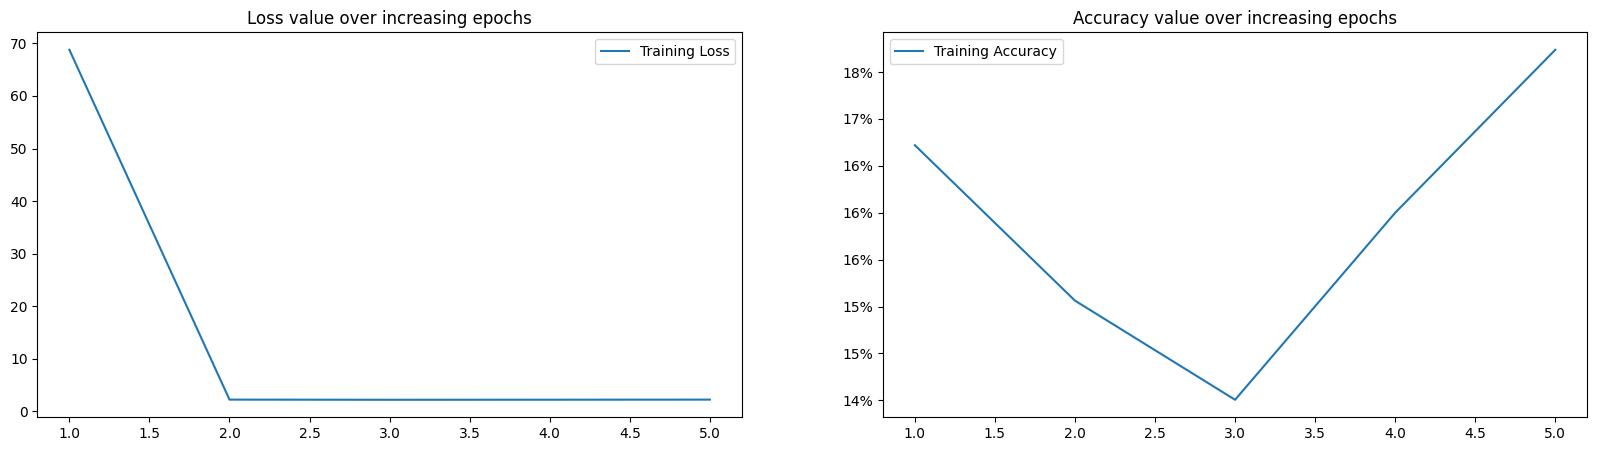

In [9]:
# 绘图
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
